# GNN

Using a simple GNN architecture to perform graph classification on a molecular dataset (MUTAG).

## Dataset: MUTAG dataset

The MUTAG dataset is a collection of chemical compounds, specifically molecules with mutagenic properties. It's used in machine learning and graph-based tasks to predict whether a molecule might cause mutations in DNA, which is crucial in drug discovery and understanding the potential harmful effects of certain chemicals on living organisms.

### The code demonstrates how to define a simple GNN model using GCNConv layers for graph classification on the MUTAG dataset. The dataset is split into training and test sets, the model is trained using the training set, and its performance is evaluated on the test set. Adjustments and improvements can be made to the GNN architecture and hyperparameters to achieve better performance based on the specific dataset and task at hand.

In [3]:
'''
!pip install torch torchvision torchaudio
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html
!pip install torch-geometric
!pip install optuna
'''

'\n!pip install torch torchvision torchaudio\n!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html\n!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html\n!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html\n!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cpu.html\n!pip install torch-geometric\n!pip install optuna\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch_geometric.nn import GCNConv
import networkx as nx

In [ ]:
from torch_geometric.nn import global_mean_pool

In [ ]:
from torch_geometric.nn import GCNConv
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

In [ ]:
import optuna

In [ ]:
# Load MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Convert dataset to pandas DataFrame
data = [data for data in dataset]

# Extract node features and label for each data point
rows = []
for d in data:
    row_data = d.x.numpy().flatten().tolist()  # Assuming the node features are flattened to a list
    row_data.append(d.y.item())  # Append the label
    rows.append(row_data)

Pivot Table:
y
1.0    3
dtype: int64


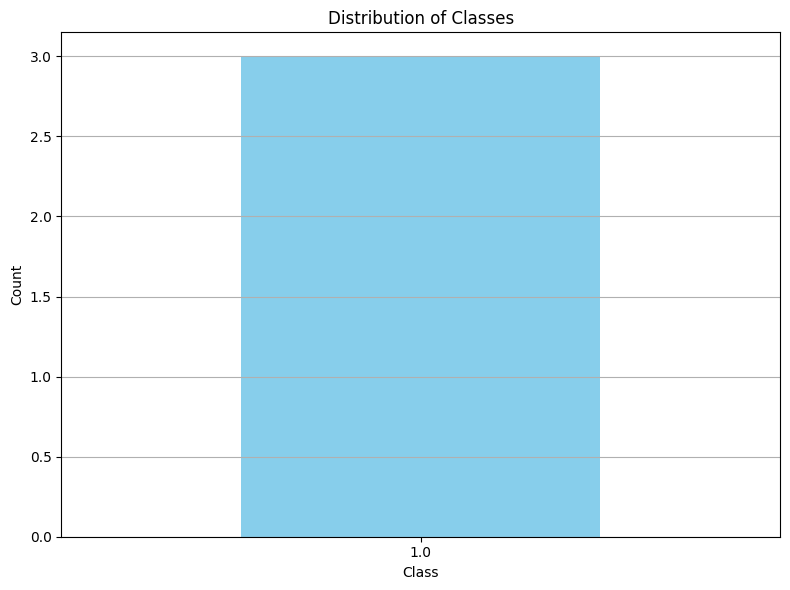

In [ ]:
# Load MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Convert dataset to pandas DataFrame
data = [data for data in dataset]

# Extract node features and label for each data point
rows = []
for d in data:
    row_data = d.x.numpy().flatten().tolist()  # Assuming the node features are flattened to a list
    row_data.append(d.y.item())  # Append the label
    rows.append(row_data)

# Determine the number of columns for the DataFrame
num_node_features = len(rows[0]) - 1  # Exclude the label column

# Create column names for DF
columns = [f'x_{i}' for i in range(196)] + ['y']

# Create the pd.DataFrame
df = pd.DataFrame(rows, columns=columns)

# Extracting pivot table
pivot_table = df.pivot_table(index='y', aggfunc='size')

# Display the pivot table
print("Pivot Table:")
print(pivot_table)

# Visualize the pivot table
plt.figure(figsize=(8, 6))
pivot_table.plot(kind='bar', color='skyblue')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


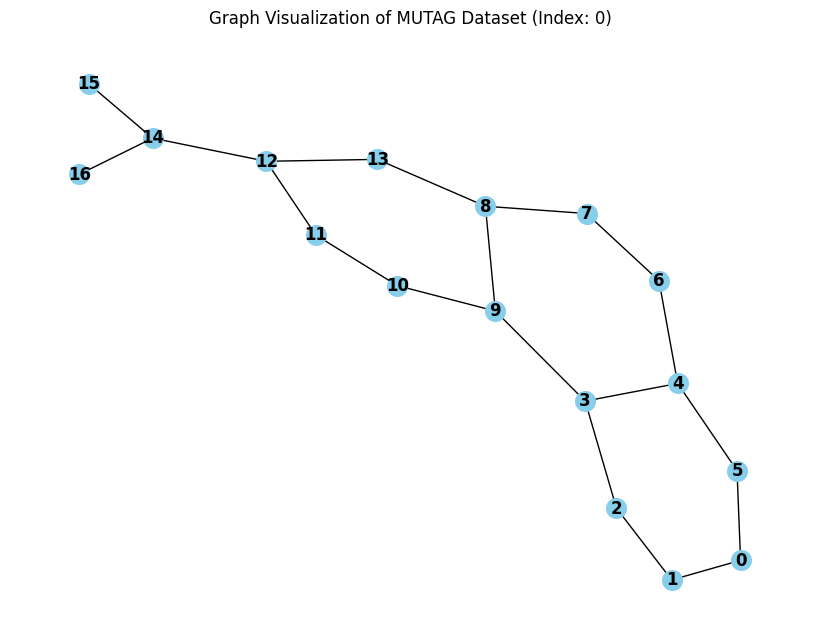

In [ ]:
# Load MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Choose a specific graph index to visualize (graph_index = 0)
graph_index = 0

# Get the graph data at the selected index
data = dataset[graph_index]

# Convert PyG data to NetworkX graph
edge_index = data.edge_index.numpy()
edge_list = edge_index.T.tolist()
G = nx.Graph(edge_list)

# Visualize First samle of MUTAG Dataset
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Define node positions using a spring layout
nx.draw(G, pos, with_labels=True, node_size=200, font_weight='bold', node_color='skyblue', edge_color='black')
plt.title(f'Graph Visualization of MUTAG Dataset (Index: {graph_index})')
plt.show()


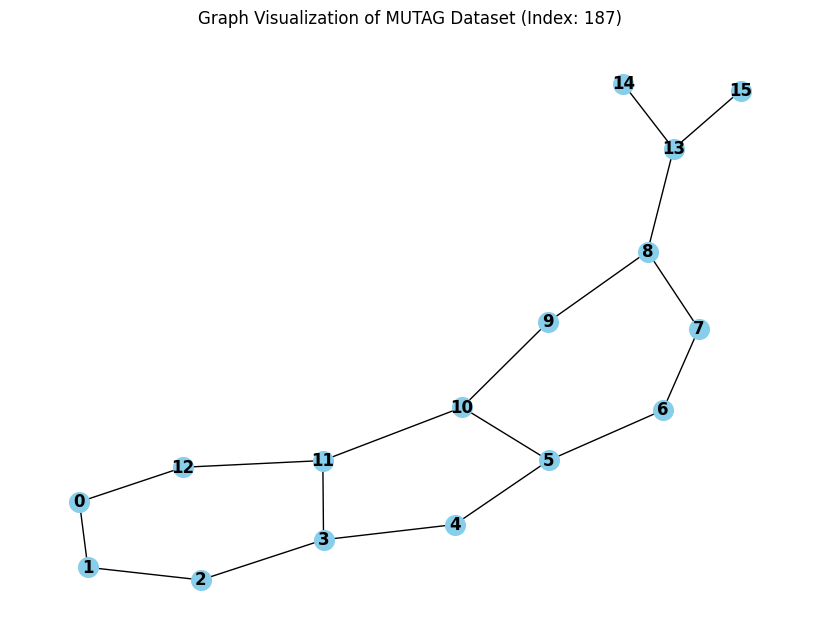

In [ ]:
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Visualize graph_index = 187
graph_index = 187

data = dataset[graph_index]

edge_index = data.edge_index.numpy()
edge_list = edge_index.T.tolist()
G = nx.Graph(edge_list)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # Define node positions using a spring layout
nx.draw(G, pos, with_labels=True, node_size=200, font_weight='bold', node_color='skyblue', edge_color='black')
plt.title(f'Graph Visualization of MUTAG Dataset (Index: {graph_index})')
plt.show()


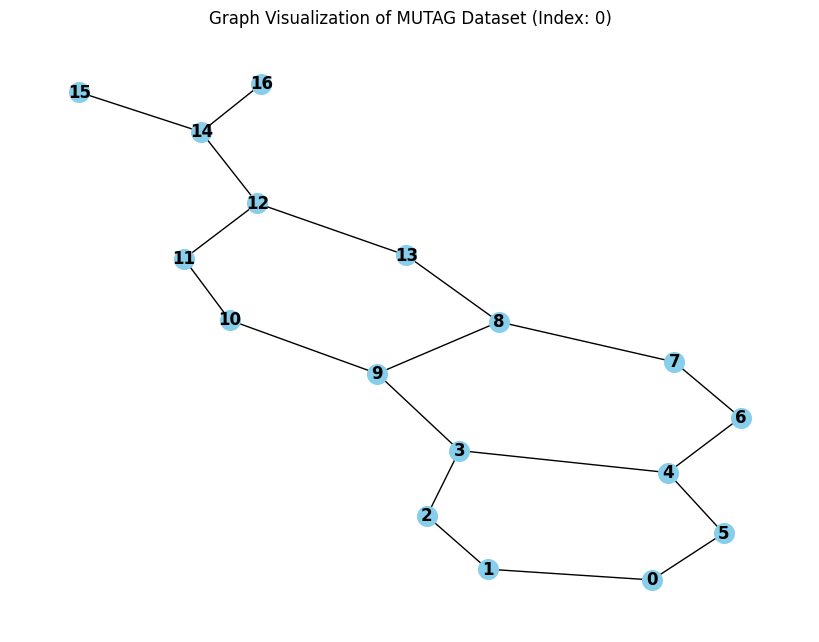

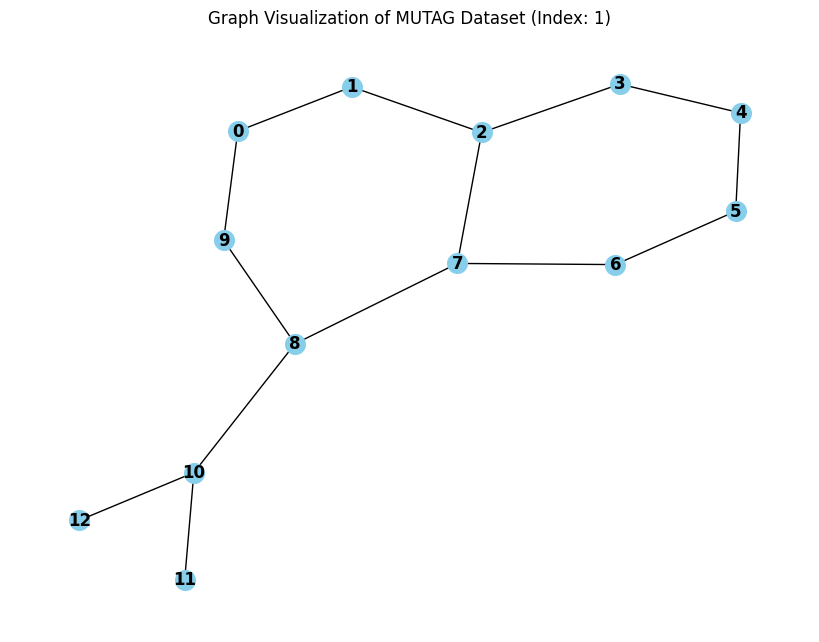

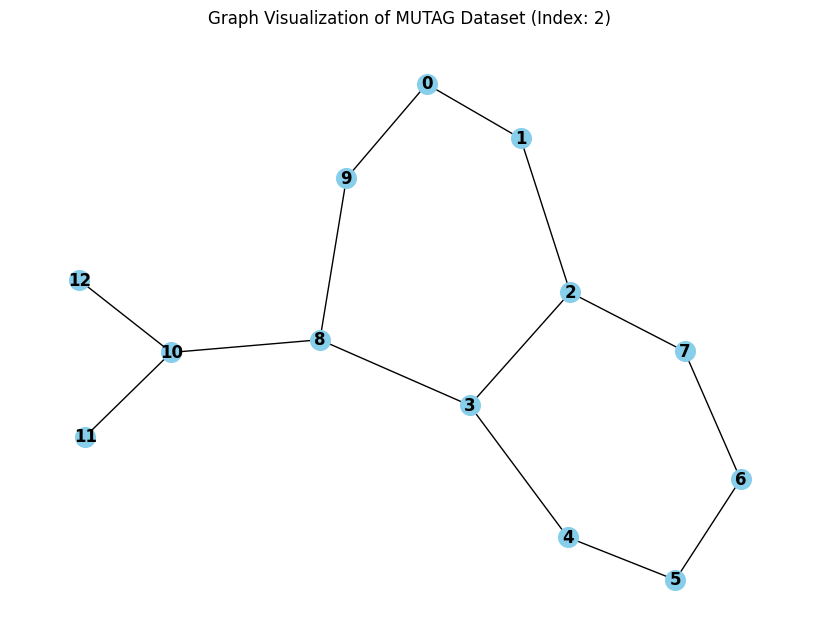

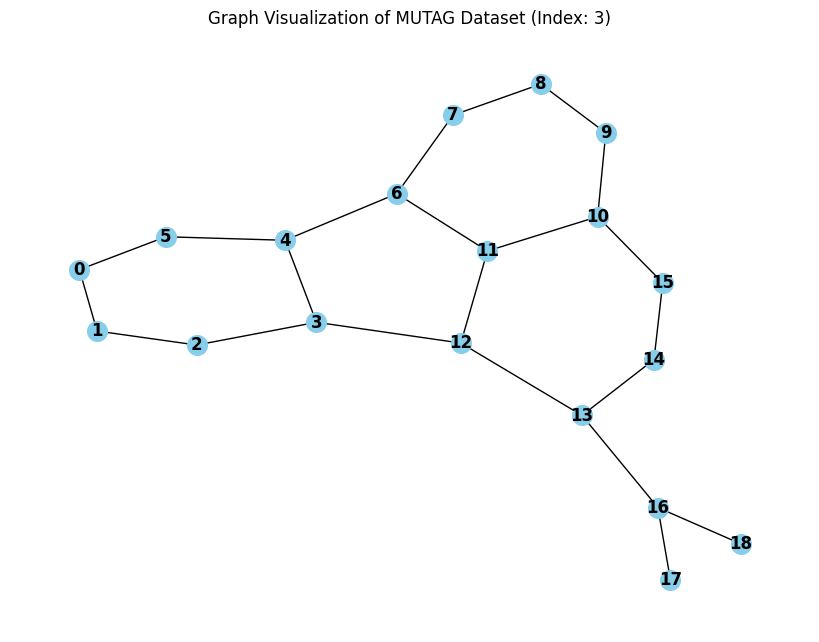

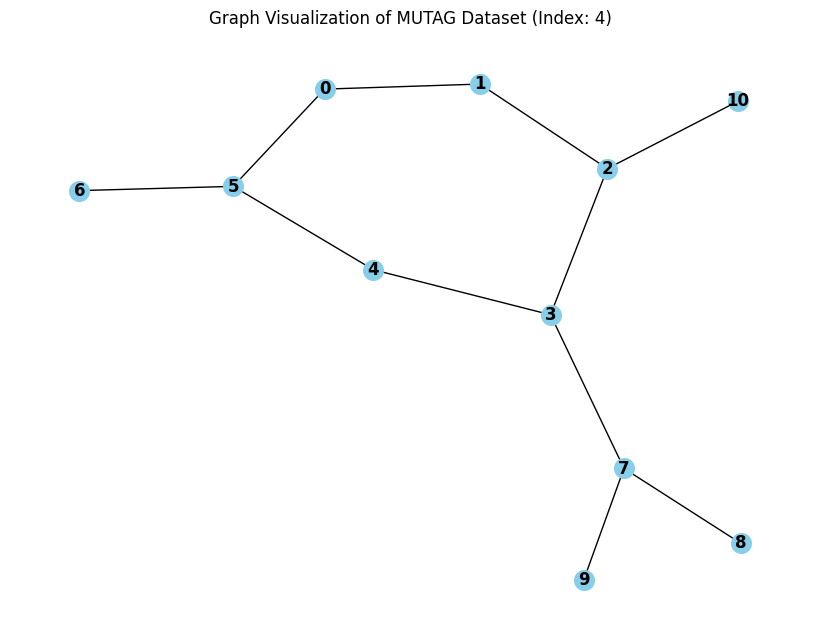

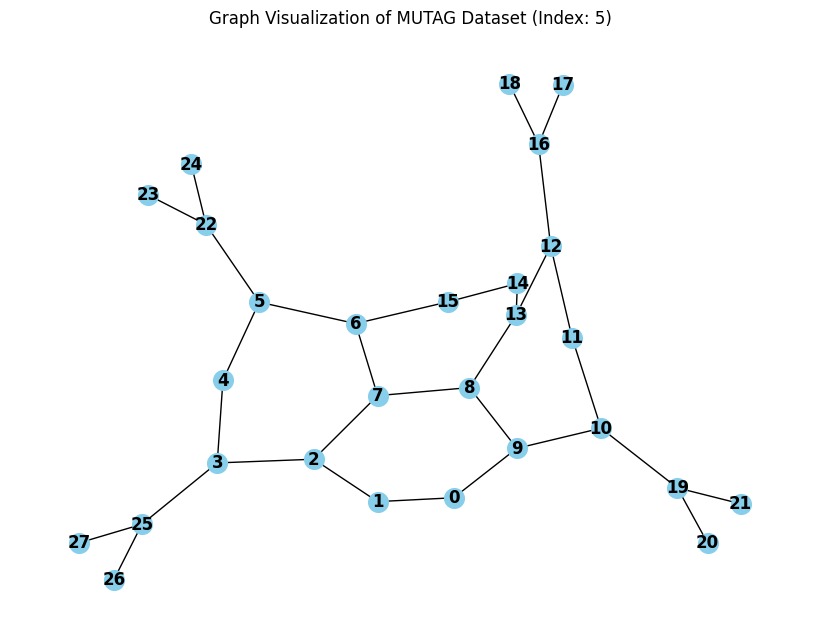

In [166]:
# Visualize First five samles of MUTAG Dataset
for Ginx in range(6):
  data = dataset[Ginx]
  edge_index = data.edge_index.numpy()
  edge_list = edge_index.T.tolist()
  G = nx.Graph(edge_list)
  # Visualize the NetworkX graph using Matplotlib
  plt.figure(figsize=(8, 6))
  pos = nx.spring_layout(G)  # Define node positions using a spring layout
  nx.draw(G, pos, with_labels=True, node_size=200, font_weight='bold', node_color='skyblue', edge_color='black')
  plt.title(f'Graph Visualization of MUTAG Dataset (Index: {Ginx})')
  plt.show()

In [ ]:
test_dataset = dataset[200:]
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
val_loader

# ML

In [ ]:
# Define a simple Graph Neural Network (GNN) for graph classification
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        # Perform global pooling (mean pooling in this case) to aggregate node features
        pooled = torch.zeros(torch.max(batch) + 1, x.size(1), device=x.device)
        count = torch.zeros(torch.max(batch) + 1, 1, device=x.device)
        for i in range(x.size(0)):
            pooled[batch[i]] += x[i]
            count[batch[i]] += 1
        pooled /= count.clamp(min=1)

        # Apply log softmax along the appropriate one dimension (dim=1) for classification
        return F.log_softmax(pooled, dim=1)

# Load a molecular MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Split the dataset into training, validation, and test sets
train_dataset = dataset[:105]
val_dataset = dataset[105:125]
test_dataset = dataset[125:]

# Define DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize GNN model
input_dim = dataset.num_node_features
hidden_dim = 64
output_dim = dataset.num_classes
model = GNNClassifier(input_dim, hidden_dim, output_dim)

# Load the best model checkpoint
#checkpoint = torch.load('/content/mutge/best_model.pth')
#model.load_state_dict(checkpoint['model_state_dict'])

# Testing the model on the test set
def test(loader):
    model.eval()
    correct = 0
    total_samples = len(loader.dataset)  # Total samples in the dataset

    if total_samples == 0:
        print("Dataset is empty. Cannot calculate accuracy.")
        return 0.0  # Return 0 accuracy if the dataset is empty

    for data in loader:
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()

    return correct / total_samples  # Calculate accuracy

# Evaluate the best model on the test set
test_acc = test(test_loader)
print(f'Test Accuracy: {test_acc:.4f}')



Test Accuracy: 0.5873


In [ ]:
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

In [ ]:
train_dataset = dataset[:150]

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
train_loader

In [ ]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        # Perform global pooling (mean pooling) to aggregate node features
        pooled = torch.zeros(torch.max(batch) + 1, x.size(1), device=x.device)
        count = torch.zeros(torch.max(batch) + 1, 1, device=x.device)
        for i in range(x.size(0)):
            pooled[batch[i]] += x[i]
            count[batch[i]] += 1
        pooled /= count.clamp(min=1)

        # Apply log softmax along the appropriate One-dimension
        return F.log_softmax(pooled, dim=1)


# Load a molecular MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Split the dataset into training and test sets
train_dataset = dataset[:150]
test_dataset = dataset[150:]

# Define DataLoader for training and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the GNN model
input_dim = dataset.num_node_features
hidden_dim = 64
output_dim = dataset.num_classes
model = GNNClassifier(input_dim, hidden_dim, output_dim)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.NLLLoss()

# Training the model
def train(epoch):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()

# Testing the model
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

# Train and test the model
for epoch in range(1, 101):
    train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')


Epoch: 1, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 2, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 3, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 4, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 5, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 6, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 7, Train Acc: 0.6600, Test Acc: 0.6842
Epoch: 8, Train Acc: 0.6667, Test Acc: 0.6842
Epoch: 9, Train Acc: 0.7200, Test Acc: 0.7632
Epoch: 10, Train Acc: 0.7400, Test Acc: 0.7368
Epoch: 11, Train Acc: 0.7467, Test Acc: 0.6842
Epoch: 12, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 13, Train Acc: 0.7667, Test Acc: 0.6842
Epoch: 14, Train Acc: 0.7600, Test Acc: 0.7105
Epoch: 15, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 16, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 17, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 18, Train Acc: 0.7333, Test Acc: 0.6579
Epoch: 19, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 20, Train Acc: 0.7400, Test Acc: 0.6579
Epoch: 21, Train Acc: 0.7467, Test Acc: 0.6579
Epoch: 22, Train Acc: 

In [ ]:
# Evaluate the best model
def test_best_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            outputs = model(data)
            _, predicted = torch.max(outputs, 1)
            total += data.y.size(0)
            correct += (predicted == data.y).sum().item()

    accuracy = correct / total
    return accuracy

# "best_model" is the best-trained model obtained during training
best_model = model

# "test_loader" is the DataLoader for the test set
test_accuracy = test_best_model(best_model, test_loader)

print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.6842


In [ ]:
# Define a simple GNN for graph classification
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)

        # Global mean pooling to aggregate node features across the entire graph
        x = global_mean_pool(x, batch)  # Use the global_mean_pool from torch_geometric.nn

        return x


# Load a molecular MUTAG dataset
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Split the dataset into training, validation, and test sets
train_dataset = dataset[:104]
val_dataset = dataset[104:124]
test_dataset = dataset[124:]

# Define DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the GNN model
input_dim = dataset.num_node_features
hidden_dim = 64
output_dim = dataset.num_classes
model = GNNClassifier(input_dim, hidden_dim, output_dim)

# Train the GNN model
def train_model(model, train_loader, optimizer, criterion, num_epochs=100):
    for epoch in range(1, num_epochs+1):
        model.train()
        for data in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, data.y)
            loss.backward()
            optimizer.step()

# Test the GNN model
def test_model(model, loader):
    model.eval()
    predictions = []
    targets = []
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            predictions.append(pred)
            targets.append(data.y)

    # Check if lists are empty
    if not predictions or not targets:
        return torch.empty(0), torch.empty(0)  # Return empty tensors if lists are empty
    else:
        return torch.cat(predictions, dim=0), torch.cat(targets, dim=0)


# Train the GNN model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
train_model(model, train_loader, optimizer, criterion)

# Get representations from the trained GNN model
train_representations, train_targets = test_model(model, train_loader)
val_representations, val_targets = test_model(model, val_loader)

# Convert representations to numpy arrays
train_representations, train_targets = train_representations.numpy(), train_targets.numpy()
val_representations, val_targets = val_representations.numpy(), val_targets.numpy()

# Train Random Forest using GNN representations
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_representations, train_targets)

# Test Random Forest model on validation set
val_predictions = rf.predict(val_representations)
val_accuracy = accuracy_score(val_targets, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Get representations from the test set
test_representations, test_targets = test_model(model, test_loader)
test_representations, test_targets = test_representations.numpy(), test_targets.numpy()

# Test Random Forest model on test set
test_predictions = rf.predict(test_representations)
test_accuracy = accuracy_score(test_targets, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Validation Accuracy: 0.8000
Test Accuracy: 0.6719


In [ ]:
# Fine-Tune the model
def objective(trial):
    # Define the hyperparameters to be optimized
    input_dim = dataset.num_node_features
    hidden_dim = trial.suggest_int('hidden_dim', 32, 128)
    output_dim = dataset.num_classes
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)

    # Initialize the GNN model with suggested hyperparameters
    model = GNNClassifier(input_dim, hidden_dim, output_dim)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Train the model using suggested hyperparameters
    train_model(model, train_loader, optimizer, criterion, num_epochs=10)

    # Evaluate on the validation set
    _, val_targets = test_model(model, val_loader)
    val_targets = val_targets.numpy()

    # Calculate validation accuracy
    val_predictions = rf.predict(val_representations)
    val_accuracy = accuracy_score(val_targets, val_predictions)

    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

best_params = study.best_params
print(f"Best hyperparameters: {best_params}")


[I 2023-11-30 21:18:08,748] A new study created in memory with name: no-name-263bc0e3-0d4f-4336-8de3-69806381b0a6
[I 2023-11-30 21:18:09,645] Trial 0 finished with value: 0.8 and parameters: {'hidden_dim': 88, 'learning_rate': 0.0008841059822107404}. Best is trial 0 with value: 0.8.
[I 2023-11-30 21:18:10,301] Trial 1 finished with value: 0.8 and parameters: {'hidden_dim': 79, 'learning_rate': 0.0004569130183595127}. Best is trial 0 with value: 0.8.
[I 2023-11-30 21:18:10,816] Trial 2 finished with value: 0.8 and parameters: {'hidden_dim': 103, 'learning_rate': 0.0005338014706760334}. Best is trial 0 with value: 0.8.
[I 2023-11-30 21:18:12,284] Trial 3 finished with value: 0.8 and parameters: {'hidden_dim': 101, 'learning_rate': 0.0017150942674922316}. Best is trial 0 with value: 0.8.
[I 2023-11-30 21:18:13,996] Trial 4 finished with value: 0.8 and parameters: {'hidden_dim': 115, 'learning_rate': 0.00024841326700825547}. Best is trial 0 with value: 0.8.
[I 2023-11-30 21:18:15,329] Tria

Best hyperparameters: {'hidden_dim': 88, 'learning_rate': 0.0008841059822107404}


In [ ]:
class GNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNClassifier, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = global_mean_pool(x, data.batch)  # Use the global_mean_pool from torch_geometric.nn
        return x

# Load a molecular dataset (e.g., MUTAG dataset)
dataset = TUDataset(root='data/MUTAG', name='MUTAG')

# Split the dataset into training, validation, and test sets
train_dataset = dataset[:145]
val_dataset = dataset[145:168]
test_dataset = dataset[168:]

# Define DataLoader for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize the GNN model with best hyperparameters
input_dim = dataset.num_node_features
hidden_dim = 88  # Updated hyperparameter value
output_dim = dataset.num_classes
model = GNNClassifier(input_dim, hidden_dim, output_dim)

# Define optimizer and loss function
learning_rate = 0.0008841059822107404  # Updated hyperparameter value
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Train the GNN model
train_model(model, train_loader, optimizer, criterion)


In [ ]:
# Train the GNN model
train_model(model, train_loader, optimizer, criterion)

# Evaluate the trained model on the validation set
val_representations, val_targets = test_model(model, val_loader)
val_representations, val_targets = val_representations.numpy(), val_targets.numpy()

# Test the Random Forest model on the validation set
val_predictions = rf.predict(val_representations)
val_accuracy = accuracy_score(val_targets, val_predictions)
print(f'Validation Accuracy: {val_accuracy:.4f}')

# Get representations from the test set
test_representations, test_targets = test_model(model, test_loader)
test_representations, test_targets = test_representations.numpy(), test_targets.numpy()

# Test the Random Forest model on the test set
test_predictions = rf.predict(test_representations)
test_accuracy = accuracy_score(test_targets, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')


Validation Accuracy: 0.7391
Test Accuracy: 0.6500


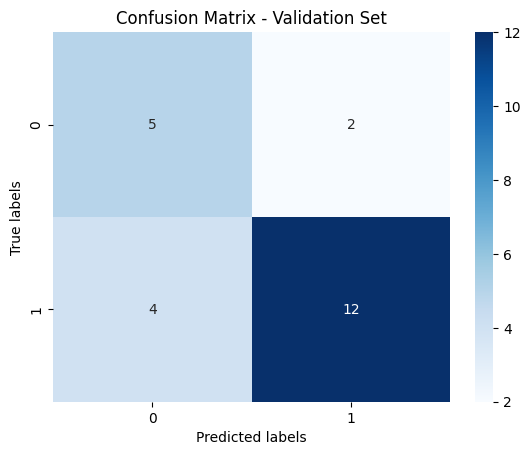

In [ ]:
conf_matrix_val = confusion_matrix(val_targets,val_predictions)
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

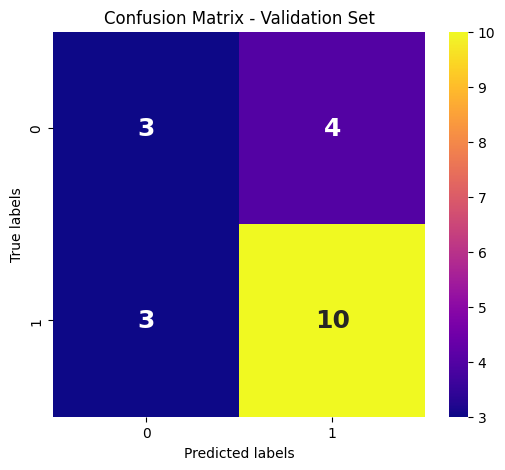

In [ ]:
conf_matrix_val = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_val, annot=True, fmt='d', cmap='plasma', annot_kws={"size": 18, "weight": "bold"})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

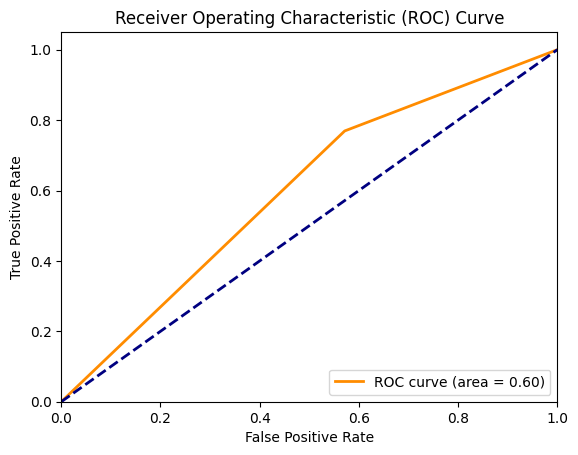

In [ ]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_targets, test_predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


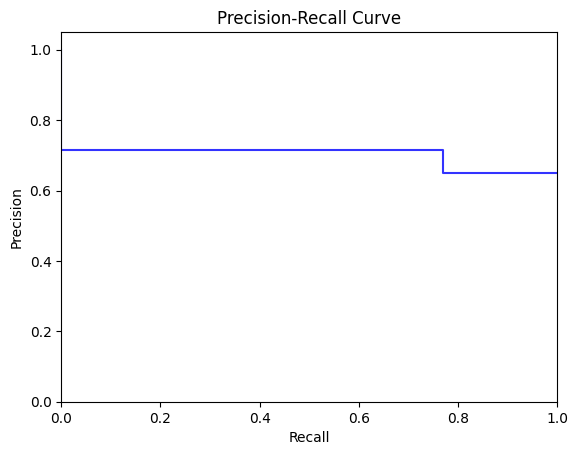

In [ ]:
# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(test_targets, test_predictions)

# Plot precision-recall curve
plt.figure()
plt.step(recall, precision, color='b', alpha=0.8, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()
